# ABBA test - 전력 사용량 예측

## import

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import sys
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings(action='ignore')
from matplotlib import font_manager,rc
rc('font', family='AppleGothic')

## 데이터

### building info
- 100개 건물 정보
- 건물 번호, 건물 유형, 연면적, 냉방 면적, 태양광 용량, ESS 저장 용량, PCS 용량

#### building_info 데이터 불러오기

In [2]:
# building_info 데이터 불러오기
building_info = pd.read_csv('input/building_info.csv')
display(building_info.head())
print(building_info.info())

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,건물기타,110634.00,39570.00,-,-,-
1,2,건물기타,122233.47,99000.00,-,-,-
2,3,건물기타,171243.00,113950.00,40,-,-
3,4,건물기타,74312.98,34419.62,60,-,-
4,5,건물기타,205884.00,150000.00,-,2557,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   건물번호          100 non-null    int64  
 1   건물유형          100 non-null    object 
 2   연면적(m2)       100 non-null    float64
 3   냉방면적(m2)      100 non-null    float64
 4   태양광용량(kW)     100 non-null    object 
 5   ESS저장용량(kWh)  100 non-null    object 
 6   PCS용량(kW)     100 non-null    object 
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ KB
None


#### column명 변환
- building_info의 column명을 편의를 위해 영어로 대체

In [3]:
# building_info의 column명을 편의를 위해 영어로 대체
building_info = building_info.rename(columns={
    '건물번호': 'building_number',
    '건물유형': 'c',
    '연면적(m2)': 'total_area',
    '냉방면적(m2)': 'cooling_area',
    '태양광용량(kW)': 'solar_power_capacity',
    'ESS저장용량(kWh)': 'ess_capacity',
    'PCS용량(kW)': 'pcs_capacity'
})

building_info.head()

,building_number,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity
0,1,건물기타,110634.00,39570.00,-,-,-
1,2,건물기타,122233.47,99000.00,-,-,-
2,3,건물기타,171243.00,113950.00,40,-,-
3,4,건물기타,74312.98,34419.62,60,-,-
4,5,건물기타,205884.00,150000.00,-,2557,1000


####  building_type 변환
- building_info의 building_type column을 편의를 위해 영어로 대체

In [207]:
# building_info의 building_type column을 편의를 위해 영어로 대체
translation_dict = {
    '건물기타': 'Other_Buildings',
    '공공': 'Public',
    '대학교': 'University',
    '데이터센터': 'Data_Center',
    '백화점및아울렛': 'Department_Store_and_Outlet',
    '병원': 'Hospital',
    '상용': 'Commercial',
    '아파트': 'Apartment',
    '연구소': 'Research_Institute',
    '지식산업센터': 'Knowledge_Industry_Center',
    '할인마트': 'Discount_Mart',
    '호텔및리조트': 'Hotel_and_Resort'
}
building_info['building_type'] = building_info['building_type'].replace(translation_dict)
building_info.head()

,building_number,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity
0,1,Other_Buildings,110634.00,39570.00,0.0,0.0,0.0
1,2,Other_Buildings,122233.47,99000.00,0.0,0.0,0.0
2,3,Other_Buildings,171243.00,113950.00,40.0,0.0,0.0
3,4,Other_Buildings,74312.98,34419.62,60.0,0.0,0.0
4,5,Other_Buildings,205884.00,150000.00,0.0,2557.0,1000.0


#### 결측치 처리 
- solar_power_capacity, ess_capacity, pcs_capacity 컬럼의 '-' 로 되어있는 결측치를 0으로 바꿔주고 object로 되어있는 type을 float64로 변환

In [5]:
# solar_power_capacity, ess_capacity, pcs_capacity 컬럼의 '-' 로 되어있는 결측치를 0으로 바꿔주고 object로 되어있는 type을 float64로 변환
building_info = building_info.replace('-',0)
building_info[['solar_power_capacity','ess_capacity','pcs_capacity']] = building_info[['solar_power_capacity','ess_capacity','pcs_capacity']].astype('float64')
display(building_info.head())
print(building_info.info())

,building_number,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity
0,1,Other_Buildings,110634.00,39570.00,0.0,0.0,0.0
1,2,Other_Buildings,122233.47,99000.00,0.0,0.0,0.0
2,3,Other_Buildings,171243.00,113950.00,40.0,0.0,0.0
3,4,Other_Buildings,74312.98,34419.62,60.0,0.0,0.0
4,5,Other_Buildings,205884.00,150000.00,0.0,2557.0,1000.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   building_number       100 non-null    int64  
 1   building_type         100 non-null    object 
 2   total_area            100 non-null    float64
 3   cooling_area          100 non-null    float64
 4   solar_power_capacity  100 non-null    float64
 5   ess_capacity          100 non-null    float64
 6   pcs_capacity          100 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 5.6+ KB
None


#### Data Cleaning

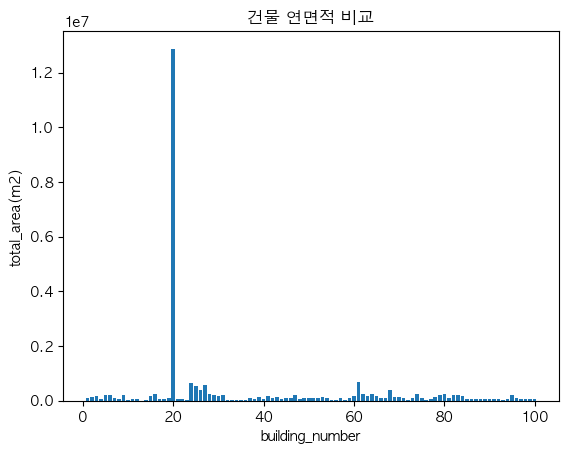

,building_number,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity
18,19,Public,90730.40,90730.00,0.0,1362.0,500.0
19,20,Public,12872877.00,10941945.00,0.0,0.0,0.0
20,21,Public,61469.67,43970.64,70.0,837.1,500.0


건물 연면적 평균: 260887.52831 (m2)
20번 건물의 연면적: [12872877.]
20번 건물의 연면적은 100개의 건물 평균의 [49.34263084]배 이다.


In [6]:
# 20번 건물이 다른 건물들에 비해서 너무 큰 total_area 값임을 확인
plt.bar(building_info.building_number,building_info.total_area)
plt.title('건물 연면적 비교')
plt.xlabel('building_number')
plt.ylabel('total_area(m2)')
plt.show()
display(building_info[18:21])

print(f"건물 연면적 평균: {building_info.total_area.mean()} (m2)")
print(f"20번 건물의 연면적: {building_info.total_area[19:20].values}")
print(f"20번 건물의 연면적은 100개의 건물 평균의 {(building_info[19:20].total_area.values)/(building_info.total_area.mean())}배 이다.")

### train_df
- train 데이터 : 100개 건물들의 2022년 06월 01일부터 2022년 08월 24일까지의 데이터
- 일시별 기온, 강수량, 풍속, 습도, 일조, 일사 정보 포함
- 전력사용량(kWh) 포함

#### train_df 데이터 불러오기

In [7]:
# train_df 데이터 불러오기
train_df = pd.read_csv('input/train.csv')
display(train_df.head())
print(train_df.info())

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_date_time  204000 non-null  object 
 1   건물번호           204000 non-null  int64  
 2   일시             204000 non-null  object 
 3   기온(C)          204000 non-null  float64
 4   강수량(mm)        43931 non-null   float64
 5   풍속(m/s)        203981 non-null  float64
 6   습도(%)          203991 non-null  float64
 7   일조(hr)         128818 non-null  float64
 8   일사(MJ/m2)      116087 non-null  float64
 9   전력소비량(kWh)     204000 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 15.6+ MB
None


#### column명 변환
- train_df의 column명을 편의를 위해 영어로 대체

In [8]:
# train_df의 column명을 편의를 위해 영어로 대체
train_df = train_df.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})

#### date_time 형식 변경 및 분활

In [9]:
# 형식 변경: 20220601 00 -> 2022-06-01 00:00:00
# object -> datetime64
train_df['date_time'] = pd.to_datetime(train_df['date_time'], format='%Y%m%d %H')

# date time feature 생성
train_df['year'] = train_df['date_time'].dt.year
train_df['month'] = train_df['date_time'].dt.month
train_df['day'] = train_df['date_time'].dt.day
train_df['hour'] = train_df['date_time'].dt.hour
train_df['day_of_week'] = train_df['date_time'].dt.dayofweek
train_df['day_of_year'] = train_df['date_time'].dt.dayofyear
train_df.head()

,num_date_time,building_number,date_time,temperature,rainfall,windspeed,humidity,sunshine,solar_radiation,power_consumption,year,month,day,hour,day_of_week,day_of_year
0,1_20220601 00,1,2022-06-01 00:00:00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28,2022,6,1,0,2,152
1,1_20220601 01,1,2022-06-01 01:00:00,18.0,NaN,1.1,45.0,NaN,NaN,1047.36,2022,6,1,1,2,152
2,1_20220601 02,1,2022-06-01 02:00:00,17.7,NaN,1.5,45.0,NaN,NaN,974.88,2022,6,1,2,2,152
3,1_20220601 03,1,2022-06-01 03:00:00,16.7,NaN,1.4,48.0,NaN,NaN,953.76,2022,6,1,3,2,152
4,1_20220601 04,1,2022-06-01 04:00:00,18.4,NaN,2.8,43.0,NaN,NaN,986.40,2022,6,1,4,2,152


#### 결측치 처리

In [10]:
# 결측치 확인
print(train_df.shape)
train_df.isnull().sum()

(204000, 16)


num_date_time             0
building_number           0
date_time                 0
temperature               0
rainfall             160069
windspeed                19
humidity                  9
sunshine              75182
solar_radiation       87913
power_consumption         0
year                      0
month                     0
day                       0
hour                      0
day_of_week               0
day_of_year               0
dtype: int64

In [11]:
# rainfall경우 204000행 중 약 80%인 160069행이 결측되었지만 우리나라의 비가 오는날이 안 오는늘의 80% 정도라 생각하여 0으로 채움
train_df.fillna({"rainfall": 0}, inplace=True)
train_df.isnull().sum()

num_date_time            0
building_number          0
date_time                0
temperature              0
rainfall                 0
windspeed               19
humidity                 9
sunshine             75182
solar_radiation      87913
power_consumption        0
year                     0
month                    0
day                      0
hour                     0
day_of_week              0
day_of_year              0
dtype: int64

In [12]:
# 결측치가 적은 windspeed, humidity 컬럼의 결측치릐 선행값으로 대체
display(train_df[~(train_df['windspeed'] >= 0)])
display(train_df[~(train_df['humidity'] >= 0)])
train_df['windspeed'].fillna(method='ffill', axis=0, inplace=True)
train_df['humidity'].fillna(method='ffill', axis=0, inplace=True)
train_df.isnull().sum()

,num_date_time,building_number,date_time,temperature,rainfall,windspeed,humidity,sunshine,solar_radiation,power_consumption,year,month,day,hour,day_of_week,day_of_year
16643,9_20220614 11,9,2022-06-14 11:00:00,17.6,0.0,NaN,NaN,NaN,NaN,2330.40,2022,6,14,11,1,165
30161,15_20220806 17,15,2022-08-06 17:00:00,35.6,0.0,NaN,NaN,NaN,NaN,1815.57,2022,8,6,17,5,218
32127,16_20220803 15,16,2022-08-03 15:00:00,30.4,0.0,NaN,77.0,0.5,2.06,5062.08,2022,8,3,15,2,215
51640,26_20220627 16,26,2022-06-27 16:00:00,27.2,3.1,NaN,93.0,0.0,0.27,5330.40,2022,6,27,16,0,178
51921,26_20220709 09,26,2022-07-09 09:00:00,26.3,0.0,NaN,84.0,0.0,0.81,2908.80,2022,7,9,9,5,190
84418,42_20220703 10,42,2022-07-03 10:00:00,29.8,0.0,NaN,66.0,1.0,2.61,3038.76,2022,7,3,10,6,184
100738,50_20220703 10,50,2022-07-03 10:00:00,29.8,0.0,NaN,66.0,1.0,2.61,3044.70,2022,7,3,10,6,184
105639,52_20220806 15,52,2022-08-06 15:00:00,33.4,0.0,NaN,72.0,0.0,NaN,2260.20,2022,8,6,15,5,218
105640,52_20220806 16,52,2022-08-06 16:00:00,33.5,0.0,NaN,73.0,0.0,NaN,2274.30,2022,8,6,16,5,218
176477,87_20220714 05,87,2022-07-14 05:00:00,21.9,0.0,NaN,NaN,NaN,NaN,519.66,2022,7,14,5,3,195


,num_date_time,building_number,date_time,temperature,rainfall,windspeed,humidity,sunshine,solar_radiation,power_consumption,year,month,day,hour,day_of_week,day_of_year
16643,9_20220614 11,9,2022-06-14 11:00:00,17.6,0.0,NaN,NaN,NaN,NaN,2330.40,2022,6,14,11,1,165
30161,15_20220806 17,15,2022-08-06 17:00:00,35.6,0.0,NaN,NaN,NaN,NaN,1815.57,2022,8,6,17,5,218
176477,87_20220714 05,87,2022-07-14 05:00:00,21.9,0.0,NaN,NaN,NaN,NaN,519.66,2022,7,14,5,3,195
176478,87_20220714 06,87,2022-07-14 06:00:00,22.3,0.0,NaN,NaN,NaN,NaN,632.88,2022,7,14,6,3,195
176479,87_20220714 07,87,2022-07-14 07:00:00,22.8,0.0,NaN,NaN,NaN,NaN,738.72,2022,7,14,7,3,195
176480,87_20220714 08,87,2022-07-14 08:00:00,23.3,0.0,NaN,NaN,NaN,NaN,1547.28,2022,7,14,8,3,195
176481,87_20220714 09,87,2022-07-14 09:00:00,23.8,0.0,NaN,NaN,NaN,NaN,2059.74,2022,7,14,9,3,195
183161,90_20220806 17,90,2022-08-06 17:00:00,35.6,0.0,NaN,NaN,NaN,NaN,2504.16,2022,8,6,17,5,218
202143,100_20220608 15,100,2022-06-08 15:00:00,24.9,0.0,NaN,NaN,NaN,NaN,880.32,2022,6,8,15,2,159


num_date_time            0
building_number          0
date_time                0
temperature              0
rainfall                 0
windspeed                0
humidity                 0
sunshine             75182
solar_radiation      87913
power_consumption        0
year                     0
month                    0
day                      0
hour                     0
day_of_week              0
day_of_year              0
dtype: int64

In [13]:
# sunshine, solar_radiation 컬름의 결측치는 밤의 경우 일조량이 없음으로 0으로 채움
train_df.fillna({"sunshine": 0, 'solar_radiation':0}, inplace=True)
train_df.isnull().sum()

num_date_time        0
building_number      0
date_time            0
temperature          0
rainfall             0
windspeed            0
humidity             0
sunshine             0
solar_radiation      0
power_consumption    0
year                 0
month                0
day                  0
hour                 0
day_of_week          0
day_of_year          0
dtype: int64

#### Data Cleaning

In [14]:
# temperature, windspeed, humidity의 값들이 정상 범위 내에 있음을 확인
for i in ['temperature', 'windspeed', 'humidity']:
    print(f"{i}의 최대값: {max(train_df[i])}")
    print(f"{i}의 평균값: {np.mean(train_df[i])}")
    print(f"{i}의 중위값: {np.median(train_df[i])}")
    print(f"{i}의 최소값: {min(train_df[i])}")
    print()

temperature의 최대값: 37.1
temperature의 평균값: 25.54352401960785
temperature의 중위값: 25.7
temperature의 최소값: 10.1

windspeed의 최대값: 13.3
windspeed의 평균값: 2.134051960784314
windspeed의 중위값: 2.0
windspeed의 최소값: 0.0

humidity의 최대값: 100.0
humidity의 평균값: 78.71651813725492
humidity의 중위값: 81.0
humidity의 최소값: 13.0



### test_df
- test 데이터 : 100개 건물들의 2022년 08월 25일부터 2022년 08월 31일까지의 데이터
- 일시별 기온, 강수량, 풍속, 습도의 예보 정보

#### test_df 데이터 불러오기

In [15]:
# test_df 데이터 불러오기
test_df = pd.read_csv('input/test.csv')
display(test_df.head())
print(test_df.info())

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16800 entries, 0 to 16799
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   num_date_time  16800 non-null  object 
 1   건물번호           16800 non-null  int64  
 2   일시             16800 non-null  object 
 3   기온(C)          16800 non-null  float64
 4   강수량(mm)        16800 non-null  float64
 5   풍속(m/s)        16800 non-null  float64
 6   습도(%)          16800 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 918.9+ KB
None


#### column명 변환
- test_df의 column명을 편의를 위해 영어로 대체

In [16]:
# test_df의 column명을 편의를 위해 영어로 대체
test_df = test_df.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})

#### date_time 형식 변경 및 분활

In [17]:
# 형식 변경: 20220601 00 -> 2022-06-01 00:00:00
# object -> datetime64
test_df['date_time'] = pd.to_datetime(test_df['date_time'], format='%Y%m%d %H')

# date time feature 생성
test_df['year'] = test_df['date_time'].dt.year
test_df['month'] = test_df['date_time'].dt.month
test_df['day'] = test_df['date_time'].dt.day
test_df['hour'] = test_df['date_time'].dt.hour
test_df['day_of_week'] = test_df['date_time'].dt.dayofweek
test_df['day_of_year'] = test_df['date_time'].dt.dayofyear
test_df.head()

,num_date_time,building_number,date_time,temperature,rainfall,windspeed,humidity,year,month,day,hour,day_of_week,day_of_year
0,1_20220825 00,1,2022-08-25 00:00:00,23.5,0.0,2.2,72,2022,8,25,0,3,237
1,1_20220825 01,1,2022-08-25 01:00:00,23.0,0.0,0.9,72,2022,8,25,1,3,237
2,1_20220825 02,1,2022-08-25 02:00:00,22.7,0.0,1.5,75,2022,8,25,2,3,237
3,1_20220825 03,1,2022-08-25 03:00:00,22.1,0.0,1.3,78,2022,8,25,3,3,237
4,1_20220825 04,1,2022-08-25 04:00:00,21.8,0.0,1.0,77,2022,8,25,4,3,237


#### 결측치 처리

In [18]:
# 결측치 확인
print(test_df.shape)
test_df.isnull().sum()

(16800, 13)


num_date_time      0
building_number    0
date_time          0
temperature        0
rainfall           0
windspeed          0
humidity           0
year               0
month              0
day                0
hour               0
day_of_week        0
day_of_year        0
dtype: int64

#### Data Cleaning

In [19]:
# temperature, windspeed, humidity의 값들이 정상 범위 내에 있음을 확인
for i in ['temperature', 'windspeed', 'humidity']:
    print(f"{i}의 최대값: {max(test_df[i])}")
    print(f"{i}의 평균값: {np.mean(test_df[i])}")
    print(f"{i}의 중위값: {np.median(test_df[i])}")
    print(f"{i}의 최소값: {min(test_df[i])}")
    print()

temperature의 최대값: 32.3
temperature의 평균값: 21.97523214285714
temperature의 중위값: 21.7
temperature의 최소값: 12.2

windspeed의 최대값: 7.0
windspeed의 평균값: 1.783404761904762
windspeed의 중위값: 1.7
windspeed의 최소값: 0.0

humidity의 최대값: 100
humidity의 평균값: 77.14803571428571
humidity의 중위값: 79.0
humidity의 최소값: 26



### Feature Engineering

#### 체감온도(WCT) feature 생성
- 체감온도 (Wind Chill Temperature): 기온과 풍속을 고려하여 인체에 느껴지는 온도를 나타내는 지표입니다. 높은 바람이 불 때, 실제 기온보다 더 춥게 느껴질 수 있습니다.

In [20]:
train_df['WCT'] = 13.12 + 0.6125*train_df['temperature'] - 11.37*(train_df['windspeed'] ** 0.16) + 0.3965*(train_df['windspeed']**0.16)*train_df['temperature']
train_df.head()

,num_date_time,building_number,date_time,temperature,rainfall,windspeed,humidity,sunshine,solar_radiation,power_consumption,year,month,day,hour,day_of_week,day_of_year,WCT
0,1_20220601 00,1,2022-06-01 00:00:00,18.6,0.0,0.9,42.0,0.0,0.0,1085.28,2022,6,1,0,2,152,20.584184
1,1_20220601 01,1,2022-06-01 01:00:00,18.0,0.0,1.1,45.0,0.0,0.0,1047.36,2022,6,1,1,2,152,19.846954
2,1_20220601 02,1,2022-06-01 02:00:00,17.7,0.0,1.5,45.0,0.0,0.0,974.88,2022,6,1,2,2,152,19.317610
3,1_20220601 03,1,2022-06-01 03:00:00,16.7,0.0,1.4,48.0,0.0,0.0,953.76,2022,6,1,3,2,152,18.337658
4,1_20220601 04,1,2022-06-01 04:00:00,18.4,0.0,2.8,43.0,0.0,0.0,986.40,2022,6,1,4,2,152,19.585934


In [21]:
test_df['WCT'] = 13.12 + 0.6125*test_df['temperature'] - 11.37*(test_df['windspeed'] ** 0.16) + 0.3965*(test_df['windspeed']**0.16)*test_df['temperature']
test_df.head()

,num_date_time,building_number,date_time,temperature,rainfall,windspeed,humidity,year,month,day,hour,day_of_week,day_of_year,WCT
0,1_20220825 00,1,2022-08-25 00:00:00,23.5,0.0,2.2,72,2022,8,25,0,3,237,25.185563
1,1_20220825 01,1,2022-08-25 01:00:00,23.0,0.0,0.9,72,2022,8,25,1,3,237,24.994620
2,1_20220825 02,1,2022-08-25 02:00:00,22.7,0.0,1.5,75,2022,8,25,2,3,237,24.495488
3,1_20220825 03,1,2022-08-25 03:00:00,22.1,0.0,1.3,78,2022,8,25,3,3,237,23.937118
4,1_20220825 04,1,2022-08-25 04:00:00,21.8,0.0,1.0,77,2022,8,25,4,3,237,23.746200


#### 불쾌 지수(THI) feature 생성
- 불쾌 지수(습도 지수) (Temperature Humidity Index): 습도와 온도를 고려하여 불쾌한 정도를 표현하는 지표입니다. 높은 습도와 높은 기온은 불쾌함을 증가시킬 수 있습니다.

In [22]:
train_df['THI'] = 9/5*train_df['temperature'] - 0.55 * (1-train_df['humidity']/100)*(9/5*train_df['humidity']-26)+32
train_df.head()

,num_date_time,building_number,date_time,temperature,rainfall,windspeed,humidity,sunshine,solar_radiation,power_consumption,year,month,day,hour,day_of_week,day_of_year,WCT,THI
0,1_20220601 00,1,2022-06-01 00:00:00,18.6,0.0,0.9,42.0,0.0,0.0,1085.28,2022,6,1,0,2,152,20.584184,49.6576
1,1_20220601 01,1,2022-06-01 01:00:00,18.0,0.0,1.1,45.0,0.0,0.0,1047.36,2022,6,1,1,2,152,19.846954,47.7625
2,1_20220601 02,1,2022-06-01 02:00:00,17.7,0.0,1.5,45.0,0.0,0.0,974.88,2022,6,1,2,2,152,19.317610,47.2225
3,1_20220601 03,1,2022-06-01 03:00:00,16.7,0.0,1.4,48.0,0.0,0.0,953.76,2022,6,1,3,2,152,18.337658,44.7856
4,1_20220601 04,1,2022-06-01 04:00:00,18.4,0.0,2.8,43.0,0.0,0.0,986.40,2022,6,1,4,2,152,19.585934,49.0061


In [23]:
test_df['THI'] = 9/5*test_df['temperature'] - 0.55 * (1-test_df['humidity']/100)*(9/5*test_df['humidity']-26)+32
test_df.head()

,num_date_time,building_number,date_time,temperature,rainfall,windspeed,humidity,year,month,day,hour,day_of_week,day_of_year,WCT,THI
0,1_20220825 00,1,2022-08-25 00:00:00,23.5,0.0,2.2,72,2022,8,25,0,3,237,25.185563,58.3456
1,1_20220825 01,1,2022-08-25 01:00:00,23.0,0.0,0.9,72,2022,8,25,1,3,237,24.994620,57.4456
2,1_20220825 02,1,2022-08-25 02:00:00,22.7,0.0,1.5,75,2022,8,25,2,3,237,24.495488,57.8725
3,1_20220825 03,1,2022-08-25 03:00:00,22.1,0.0,1.3,78,2022,8,25,3,3,237,23.937118,57.9376
4,1_20220825 04,1,2022-08-25 04:00:00,21.8,0.0,1.0,77,2022,8,25,4,3,237,23.746200,56.9961


#### 휴일(holiday) feature 생성
- 2022.6.4 ~2022.8.31 사이의 주말, 공휴일 여부

In [24]:
holiday = ['2022-06-01', '2022-06-04', '2022-06-05', '2022-06-06', '2022-06-11', '2022-06-12', '2022-06-18',
           '2022-06-19', '2022-06-25', '2022-06-26', '2022-07-02', '2022-07-03', '2022-07-09', '2022-07-10',
           '2022-07-16', '2022-07-17', '2022-07-23', '2022-07-24', '2022-07-30', '2022-07-31', '2022-08-06',
           '2022-08-07', '2022-08-13', '2022-08-14', '2022-08-15', '2022-08-20', '2022-08-21', '2022-08-27',
           '2022-08-28']

In [25]:
train_df['holiday'] = train_df['date_time'].dt.date.astype('str').isin(holiday)
train_df = train_df.replace({'holiday':{False: 0, True: 1}})
train_df[train_df['holiday']==1].head()

,num_date_time,building_number,date_time,temperature,rainfall,windspeed,humidity,sunshine,solar_radiation,power_consumption,year,month,day,hour,day_of_week,day_of_year,WCT,THI,holiday
0,1_20220601 00,1,2022-06-01 00:00:00,18.6,0.0,0.9,42.0,0.0,0.0,1085.28,2022,6,1,0,2,152,20.584184,49.6576,1
1,1_20220601 01,1,2022-06-01 01:00:00,18.0,0.0,1.1,45.0,0.0,0.0,1047.36,2022,6,1,1,2,152,19.846954,47.7625,1
2,1_20220601 02,1,2022-06-01 02:00:00,17.7,0.0,1.5,45.0,0.0,0.0,974.88,2022,6,1,2,2,152,19.317610,47.2225,1
3,1_20220601 03,1,2022-06-01 03:00:00,16.7,0.0,1.4,48.0,0.0,0.0,953.76,2022,6,1,3,2,152,18.337658,44.7856,1
4,1_20220601 04,1,2022-06-01 04:00:00,18.4,0.0,2.8,43.0,0.0,0.0,986.40,2022,6,1,4,2,152,19.585934,49.0061,1


In [26]:
test_df['holiday'] = test_df['date_time'].dt.date.astype('str').isin(holiday)
test_df = test_df.replace({'holiday':{False: 0, True: 1}})
test_df[test_df['holiday']==1].head()

,num_date_time,building_number,date_time,temperature,rainfall,windspeed,humidity,year,month,day,hour,day_of_week,day_of_year,WCT,THI,holiday
48,1_20220827 00,1,2022-08-27 00:00:00,23.1,0.0,2.2,82,2022,8,27,0,5,239,24.760638,61.5416,1
49,1_20220827 01,1,2022-08-27 01:00:00,23.2,0.0,2.6,80,2022,8,27,1,5,239,24.800145,60.7800,1
50,1_20220827 02,1,2022-08-27 02:00:00,21.0,15.6,5.4,88,2022,8,27,2,5,239,21.996325,61.0616,1
51,1_20220827 03,1,2022-08-27 03:00:00,20.7,2.0,2.7,91,2022,8,27,3,5,239,22.091585,62.4389,1
52,1_20220827 04,1,2022-08-27 04:00:00,19.4,0.0,3.2,85,2022,8,27,4,5,239,20.572294,56.4425,1


### 데이터 저장(for ML, DL)

In [27]:
train_df_dl = train_df.copy()
test_df_dl = test_df.copy()

# train_df와 test_df에 건물정보를 병합한 후 train_df와 test_df의 features을 동일하게 구성함 
print('building_info')
display(building_info.head())
display(building_info.dtypes)
print('-'*150)
print('train_df_dl')
train_df_dl = train_df_dl[['num_date_time', 'building_number', 'date_time', 'temperature',
       'rainfall', 'windspeed', 'humidity', 'year', 'month', 'day',
       'hour', 'day_of_week', 'day_of_year', 'WCT', 'THI', 'holiday', 'power_consumption']]
train_df_dl = pd.merge(train_df_dl, building_info, on='building_number', how='left')
temp = train_df_dl.pop('power_consumption')
train_df_dl['power_consumption'] = temp
display(train_df_dl.head())
display(train_df_dl.dtypes)
print('-'*150)
print('test_df_dl')
test_df_dl = test_df_dl[['num_date_time', 'building_number', 'date_time', 'temperature',
       'rainfall', 'windspeed', 'humidity', 'year', 'month', 'day',
       'hour', 'day_of_week', 'day_of_year', 'WCT', 'THI', 'holiday']]
test_df_dl = pd.merge(test_df_dl, building_info, on='building_number', how='left')
display(test_df_dl.head())
display(test_df_dl.dtypes)

for i, j in zip([building_info, train_df_dl, test_df_dl],['building_info', 'train_df_dl', 'test_df_dl']):
    pd.to_pickle(i, f"./processed_data/{j}.pkl")
    print(f"{j}.pkl 저장 완료")

building_info


,building_number,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity
0,1,Other_Buildings,110634.00,39570.00,0.0,0.0,0.0
1,2,Other_Buildings,122233.47,99000.00,0.0,0.0,0.0
2,3,Other_Buildings,171243.00,113950.00,40.0,0.0,0.0
3,4,Other_Buildings,74312.98,34419.62,60.0,0.0,0.0
4,5,Other_Buildings,205884.00,150000.00,0.0,2557.0,1000.0


building_number           int64
building_type            object
total_area              float64
cooling_area            float64
solar_power_capacity    float64
ess_capacity            float64
pcs_capacity            float64
dtype: object

------------------------------------------------------------------------------------------------------------------------------------------------------
train_df_dl


,num_date_time,building_number,date_time,temperature,rainfall,windspeed,humidity,year,month,day,hour,day_of_week,day_of_year,WCT,THI,holiday,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity,power_consumption
0,1_20220601 00,1,2022-06-01 00:00:00,18.6,0.0,0.9,42.0,2022,6,1,0,2,152,20.584184,49.6576,1,Other_Buildings,110634.0,39570.0,0.0,0.0,0.0,1085.28
1,1_20220601 01,1,2022-06-01 01:00:00,18.0,0.0,1.1,45.0,2022,6,1,1,2,152,19.846954,47.7625,1,Other_Buildings,110634.0,39570.0,0.0,0.0,0.0,1047.36
2,1_20220601 02,1,2022-06-01 02:00:00,17.7,0.0,1.5,45.0,2022,6,1,2,2,152,19.317610,47.2225,1,Other_Buildings,110634.0,39570.0,0.0,0.0,0.0,974.88
3,1_20220601 03,1,2022-06-01 03:00:00,16.7,0.0,1.4,48.0,2022,6,1,3,2,152,18.337658,44.7856,1,Other_Buildings,110634.0,39570.0,0.0,0.0,0.0,953.76
4,1_20220601 04,1,2022-06-01 04:00:00,18.4,0.0,2.8,43.0,2022,6,1,4,2,152,19.585934,49.0061,1,Other_Buildings,110634.0,39570.0,0.0,0.0,0.0,986.40


num_date_time                   object
building_number                  int64
date_time               datetime64[ns]
temperature                    float64
rainfall                       float64
windspeed                      float64
humidity                       float64
year                             int32
month                            int32
day                              int32
hour                             int32
day_of_week                      int32
day_of_year                      int32
WCT                            float64
THI                            float64
holiday                          int64
building_type                   object
total_area                     float64
cooling_area                   float64
solar_power_capacity           float64
ess_capacity                   float64
pcs_capacity                   float64
power_consumption              float64
dtype: object

------------------------------------------------------------------------------------------------------------------------------------------------------
test_df_dl


,num_date_time,building_number,date_time,temperature,rainfall,windspeed,humidity,year,month,day,hour,day_of_week,day_of_year,WCT,THI,holiday,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity
0,1_20220825 00,1,2022-08-25 00:00:00,23.5,0.0,2.2,72,2022,8,25,0,3,237,25.185563,58.3456,0,Other_Buildings,110634.0,39570.0,0.0,0.0,0.0
1,1_20220825 01,1,2022-08-25 01:00:00,23.0,0.0,0.9,72,2022,8,25,1,3,237,24.994620,57.4456,0,Other_Buildings,110634.0,39570.0,0.0,0.0,0.0
2,1_20220825 02,1,2022-08-25 02:00:00,22.7,0.0,1.5,75,2022,8,25,2,3,237,24.495488,57.8725,0,Other_Buildings,110634.0,39570.0,0.0,0.0,0.0
3,1_20220825 03,1,2022-08-25 03:00:00,22.1,0.0,1.3,78,2022,8,25,3,3,237,23.937118,57.9376,0,Other_Buildings,110634.0,39570.0,0.0,0.0,0.0
4,1_20220825 04,1,2022-08-25 04:00:00,21.8,0.0,1.0,77,2022,8,25,4,3,237,23.746200,56.9961,0,Other_Buildings,110634.0,39570.0,0.0,0.0,0.0


num_date_time                   object
building_number                  int64
date_time               datetime64[ns]
temperature                    float64
rainfall                       float64
windspeed                      float64
humidity                         int64
year                             int32
month                            int32
day                              int32
hour                             int32
day_of_week                      int32
day_of_year                      int32
WCT                            float64
THI                            float64
holiday                          int64
building_type                   object
total_area                     float64
cooling_area                   float64
solar_power_capacity           float64
ess_capacity                   float64
pcs_capacity                   float64
dtype: object

building_info.pkl 저장 완료
train_df_dl.pkl 저장 완료
test_df_dl.pkl 저장 완료


## 분석

### 건물 기본 정보

- 100개의 building_number
- 12가지 building_type
>Other_Buildings       15\
Public          8\
University         8\
Department_Store_and_Outlet     8\
Hospital          8\
Commercial          8\
Apartment         8\
Research_Institute         8\
Knowledge_Industry_Center      8\
Discount_Mart        8\
Hotel_and_Resort      8\
Data_Center       5

- 태양광용량(kW)(solar_power_capacity) : 태양광 발전 설비가 설치된 건물 36개소
> 태양광을 사용하여 전력을 생산할 수 있는 능력


- ESS 시스템 : ESS 시스템 베터리 + PCS(Power Conversion System)이 설치된 건물 5개소
    - ESS 저장용량(kWh): (ESS 시스템 베터리 용량)
>생산된 전기에너지를 저장하여 전력 이 필요한 시기에 사용할 수 있게 하는 에너지 솔루션
    - PCS(Power Conversion System): ESS 내 전력변환장치 
> PCS는 저장된 에너지를 효율적으로 변환하고 제어하는 역할\
PCS의 용량은 ESS에서 저장된 에너지를 공급할 수 있는 능력을 나타낸다

\* 태양광 발전 설비와 ESS 시스템이 모두 설치된 건물: 2개소

In [28]:
# 건물수
print(f'buildings: {len(building_info.building_number.unique())}개',end='\n\n')

# 건물유형
print(f'building_type {len(building_info.building_type.value_counts())}가지: \n{building_info.building_type.value_counts()}',end='\n\n')

# 태양광 발전 설비가 설치된 건물 36개소 
print(f"태양광 발전 설비가 설치된 건물: {len(building_info[building_info['solar_power_capacity'] != 0])}개소", end='\n\n')

# ESS 시스템이 설치된 건물 
print(f"ESS 시스템이 설치된 건물: {len(building_info[building_info[['ess_capacity', 'pcs_capacity']].sum(axis=1) != 0])}개소", end='\n\n')

# 태양광 발전 설비와 ESS 시스템이 모두 설치된 건물
print(f"태양광 발전 설비와 ESS시스템이 모두 설치된 건물: {len(building_info[(building_info['solar_power_capacity'] != 0) & (building_info[['ess_capacity', 'pcs_capacity']].sum(axis=1) != 0)])}개소", end='\n\n')

buildings: 100개

building_type 12가지: 
building_type
Other_Buildings                15
Public                          8
University                      8
Department_Store_and_Outlet     8
Hospital                        8
Commercial                      8
Apartment                       8
Research_Institute              8
Knowledge_Industry_Center       8
Discount_Mart                   8
Hotel_and_Resort                8
Data_Center                     5
Name: count, dtype: int64

태양광 발전 설비가 설치된 건물: 36개소

ESS 시스템이 설치된 건물: 5개소

태양광 발전 설비와 ESS시스템이 모두 설치된 건물: 2개소



### 태양광 발전설비 설치 비율

In [29]:
# 태양광발전설비가 설치되어있는 시설 확인
print(f"태양광 발전설비가 설치되어있는 시설: {len(building_info[building_info['solar_power_capacity'] != 0])}개소")
display(building_info[building_info['solar_power_capacity'] != 0])

# 건물유형별 건물 수
building_type = building_info.value_counts('building_type')
building_type = building_type.reset_index()
building_type = building_type.rename(columns={'count':'buildings'})

# 건물유형별 태양광발전설비가 설치되어있는 건물 수
building_type_solar = building_info[building_info['solar_power_capacity'] != 0].value_counts('building_type')
building_type_solar = building_type_solar.reset_index()
building_type_solar = building_type_solar.rename(columns={'count':'solar_power_facilities'})

# 건물유형별 태양광발전설비 설치 비율
building_type_solar_rate = building_type.merge(building_type_solar, how='outer', on='building_type')
building_type_solar_rate = building_type_solar_rate.replace(np.nan,0)
building_type_solar_rate = building_type_solar_rate.set_index('building_type')
building_type_solar_rate['solar_power_facilities_rate'] = (building_type_solar_rate['solar_power_facilities'] / building_type_solar_rate['buildings'])*100
building_type_solar_rate = building_type_solar_rate.sort_values(['solar_power_facilities_rate'], ascending=False)

# total 행 생성
building_type_solar_rate.loc['total', : ] = building_type_solar_rate.iloc[:,:].sum(axis=0)
building_type_solar_rate = building_type_solar_rate.astype('int')
building_type_solar_rate.iloc[-1:,-1:] = np.nan

display(building_type_solar_rate)

태양광 발전설비가 설치되어있는 시설: 36개소


,building_number,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity
2,3,Other_Buildings,171243.000,113950.00,40.00,0.0,0.0
3,4,Other_Buildings,74312.980,34419.62,60.00,0.0,0.0
10,11,Other_Buildings,45956.560,13190.98,447.20,0.0,0.0
11,12,Other_Buildings,70163.100,3598.21,130.60,0.0,0.0
13,14,Other_Buildings,16844.160,14102.92,56.00,0.0,0.0
15,16,Public,240038.000,95175.00,20.00,0.0,0.0
17,18,Public,75624.560,39915.10,64.80,0.0,0.0
20,21,Public,61469.670,43970.64,70.00,837.1,500.0
21,22,Public,61375.470,19800.00,110.00,0.0,0.0
23,24,University,659696.910,516097.85,97.65,0.0,0.0


,buildings,solar_power_facilities,solar_power_facilities_rate
building_type,,,
University,8,8,100.0
Research_Institute,8,7,87.0
Hospital,8,5,62.0
Public,8,4,50.0
Commercial,8,3,37.0
Other_Buildings,15,5,33.0
Discount_Mart,8,2,25.0
Department_Store_and_Outlet,8,1,12.0
Hotel_and_Resort,8,1,12.0


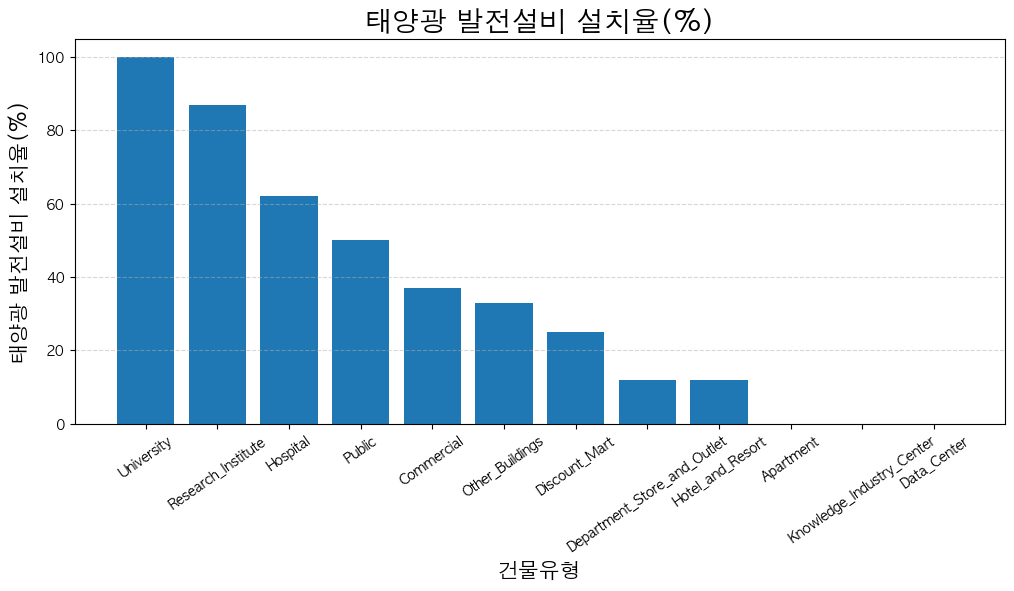

In [30]:
plt.figure(figsize=(12,5))
plt.bar(building_type_solar_rate.index, building_type_solar_rate['solar_power_facilities_rate'])
plt.title('태양광 발전설비 설치율(%)', size = 20, weight='bold')
plt.grid(True, axis='y', alpha=0.5, linestyle='--')
plt.xlabel('건물유형', size = 15)
plt.xticks(rotation=35)
plt.ylabel('태양광 발전설비 설치율(%)', size = 15)
plt.show()

- 대학교, 연구소, 병원 순으로 태양광 발전설비 설치율이 높음
- 아파트, 지식산업센터, 데이터센터에는 태양광 발전설비를 설치하지 않음

### 상관관계 분석
- 정도가 크지 않았지만 `power_consumption`와 `solar_radiation`, `temperature`,`WCT` 순으로 높은 상관관계를 보임

In [31]:
# 데이터 프레임 병합
train_df = pd.merge(train_df, building_info, on='building_number', how='left')
temp = train_df.pop('power_consumption')
train_df['power_consumption'] = temp
test_df = pd.merge(test_df, building_info, on='building_number', how='left')
display(train_df.head(), test_df.head())

,num_date_time,building_number,date_time,temperature,rainfall,windspeed,humidity,sunshine,solar_radiation,year,month,day,hour,day_of_week,day_of_year,WCT,THI,holiday,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity,power_consumption
0,1_20220601 00,1,2022-06-01 00:00:00,18.6,0.0,0.9,42.0,0.0,0.0,2022,6,1,0,2,152,20.584184,49.6576,1,Other_Buildings,110634.0,39570.0,0.0,0.0,0.0,1085.28
1,1_20220601 01,1,2022-06-01 01:00:00,18.0,0.0,1.1,45.0,0.0,0.0,2022,6,1,1,2,152,19.846954,47.7625,1,Other_Buildings,110634.0,39570.0,0.0,0.0,0.0,1047.36
2,1_20220601 02,1,2022-06-01 02:00:00,17.7,0.0,1.5,45.0,0.0,0.0,2022,6,1,2,2,152,19.317610,47.2225,1,Other_Buildings,110634.0,39570.0,0.0,0.0,0.0,974.88
3,1_20220601 03,1,2022-06-01 03:00:00,16.7,0.0,1.4,48.0,0.0,0.0,2022,6,1,3,2,152,18.337658,44.7856,1,Other_Buildings,110634.0,39570.0,0.0,0.0,0.0,953.76
4,1_20220601 04,1,2022-06-01 04:00:00,18.4,0.0,2.8,43.0,0.0,0.0,2022,6,1,4,2,152,19.585934,49.0061,1,Other_Buildings,110634.0,39570.0,0.0,0.0,0.0,986.40


,num_date_time,building_number,date_time,temperature,rainfall,windspeed,humidity,year,month,day,hour,day_of_week,day_of_year,WCT,THI,holiday,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity
0,1_20220825 00,1,2022-08-25 00:00:00,23.5,0.0,2.2,72,2022,8,25,0,3,237,25.185563,58.3456,0,Other_Buildings,110634.0,39570.0,0.0,0.0,0.0
1,1_20220825 01,1,2022-08-25 01:00:00,23.0,0.0,0.9,72,2022,8,25,1,3,237,24.994620,57.4456,0,Other_Buildings,110634.0,39570.0,0.0,0.0,0.0
2,1_20220825 02,1,2022-08-25 02:00:00,22.7,0.0,1.5,75,2022,8,25,2,3,237,24.495488,57.8725,0,Other_Buildings,110634.0,39570.0,0.0,0.0,0.0
3,1_20220825 03,1,2022-08-25 03:00:00,22.1,0.0,1.3,78,2022,8,25,3,3,237,23.937118,57.9376,0,Other_Buildings,110634.0,39570.0,0.0,0.0,0.0
4,1_20220825 04,1,2022-08-25 04:00:00,21.8,0.0,1.0,77,2022,8,25,4,3,237,23.746200,56.9961,0,Other_Buildings,110634.0,39570.0,0.0,0.0,0.0


In [32]:
# 사용하지 않을 컬럼 drop
train_df_corr = train_df.copy()
train_df_corr = train_df_corr.drop(columns=['num_date_time', 'building_number', 'date_time', 'year', 'month', 'day', 'hour', 'day_of_week', 'day_of_year', 'building_type'])
train_df_corr

,temperature,rainfall,windspeed,humidity,sunshine,solar_radiation,WCT,THI,holiday,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity,power_consumption
0,18.6,0.0,0.9,42.0,0.0,0.0,20.584184,49.6576,1,110634.00,39570.00,0.0,0.0,0.0,1085.28
1,18.0,0.0,1.1,45.0,0.0,0.0,19.846954,47.7625,1,110634.00,39570.00,0.0,0.0,0.0,1047.36
2,17.7,0.0,1.5,45.0,0.0,0.0,19.317610,47.2225,1,110634.00,39570.00,0.0,0.0,0.0,974.88
3,16.7,0.0,1.4,48.0,0.0,0.0,18.337658,44.7856,1,110634.00,39570.00,0.0,0.0,0.0,953.76
4,18.4,0.0,2.8,43.0,0.0,0.0,19.585934,49.0061,1,110634.00,39570.00,0.0,0.0,0.0,986.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,23.1,0.0,0.9,86.0,0.5,0.0,25.094857,63.6624,0,57497.84,40035.23,0.0,0.0,0.0,881.04
203996,22.4,0.0,1.3,86.0,0.0,0.0,24.244918,62.4024,0,57497.84,40035.23,0.0,0.0,0.0,798.96
203997,21.3,0.0,1.0,92.0,0.0,0.0,23.241700,64.1976,0,57497.84,40035.23,0.0,0.0,0.0,825.12
203998,21.0,0.0,0.3,94.0,0.0,0.0,23.472275,65.0744,0,57497.84,40035.23,0.0,0.0,0.0,640.08


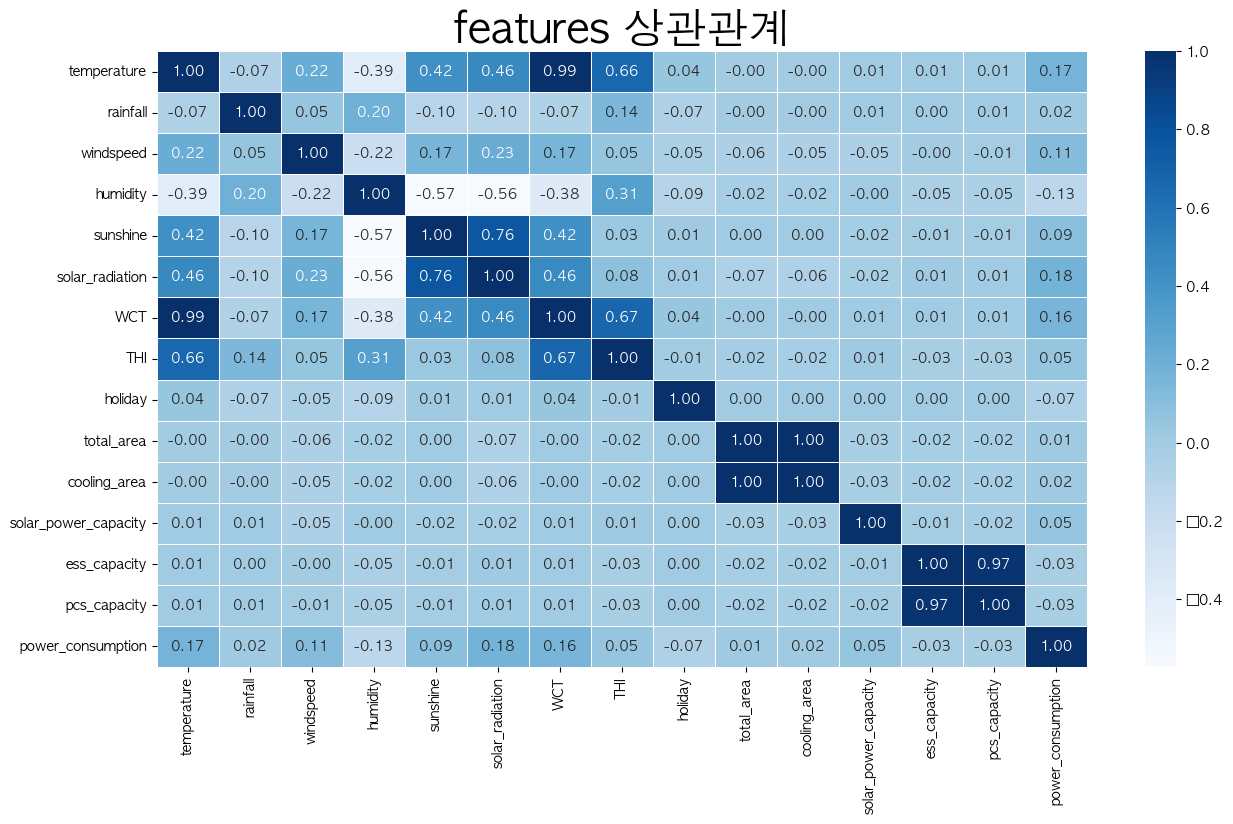

In [37]:
# 상관관계 heatmap
plt.figure(figsize=(15,8))
sns.heatmap(data = train_df_corr.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')
plt.title('features 상관관계', size=30)
plt.show()

### 시각화

#### 요일별 전력사용량 총합

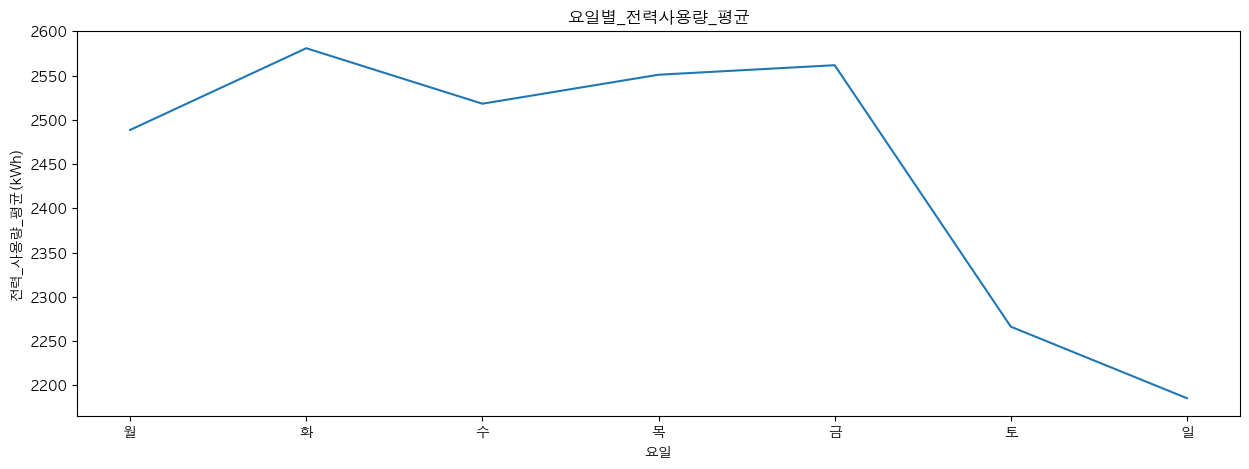

In [209]:
요일별_전력사용량_평균 = train_df.groupby('day_of_week')['power_consumption'].mean()
plt.figure(figsize=(15, 5))
plt.plot(['월', '화', '수', '목', '금', '토', '일'],요일별_전력사용량_평균.values)
plt.title('요일별_전력사용량_평균')
plt.xlabel('요일')
plt.ylabel('전력_사용량_평균(kWh)')
plt.show()

#### 건물별_요일별_전력사용량_평균

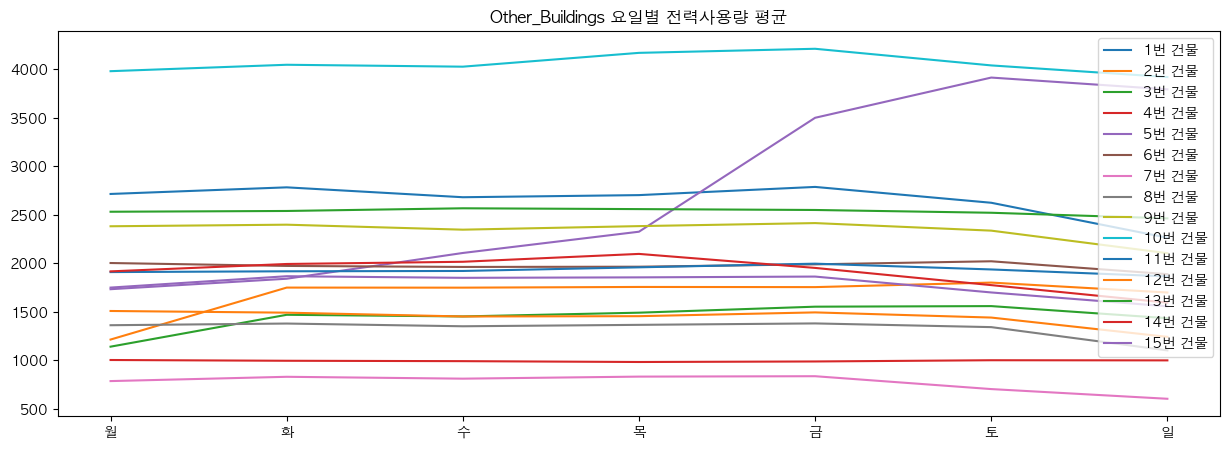

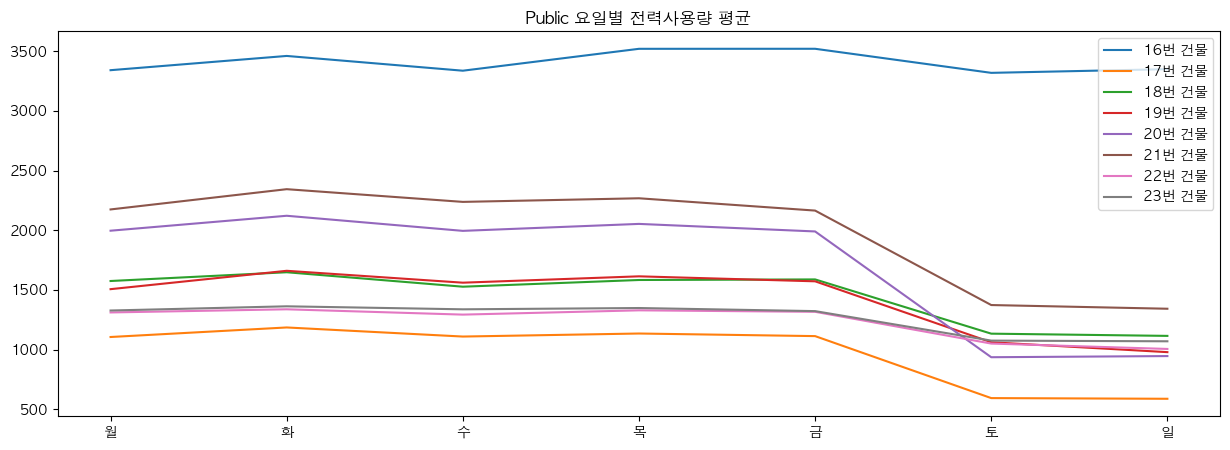

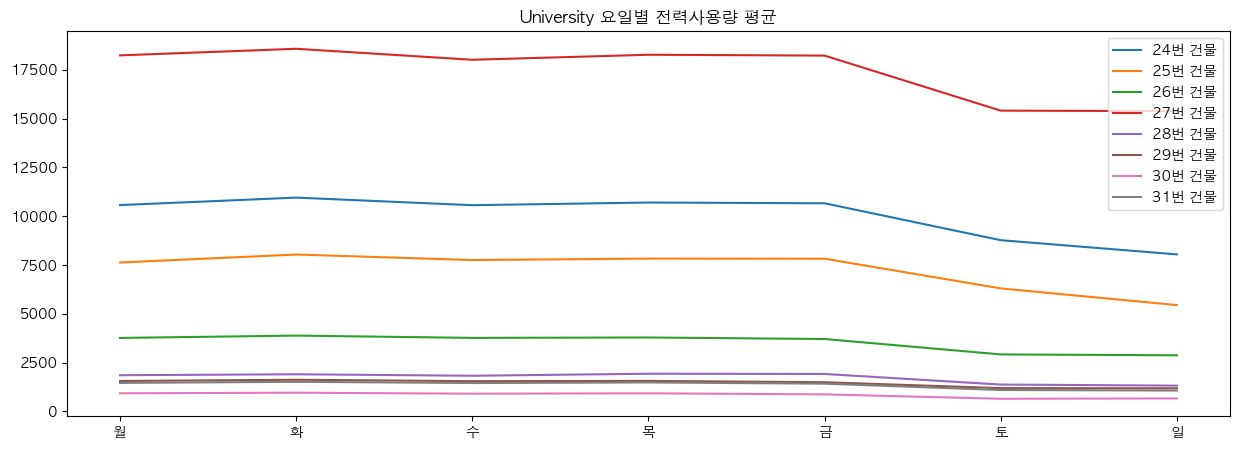

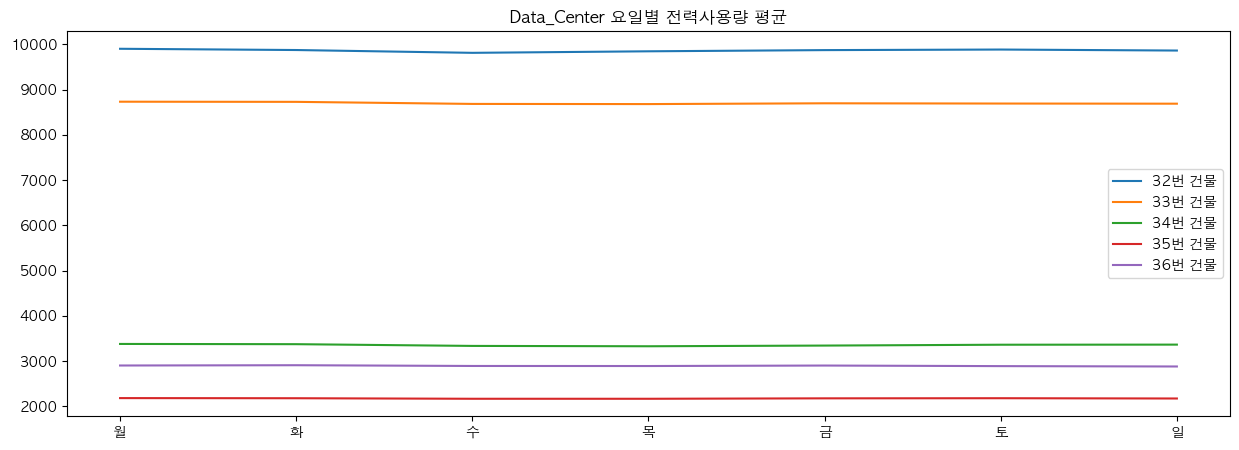

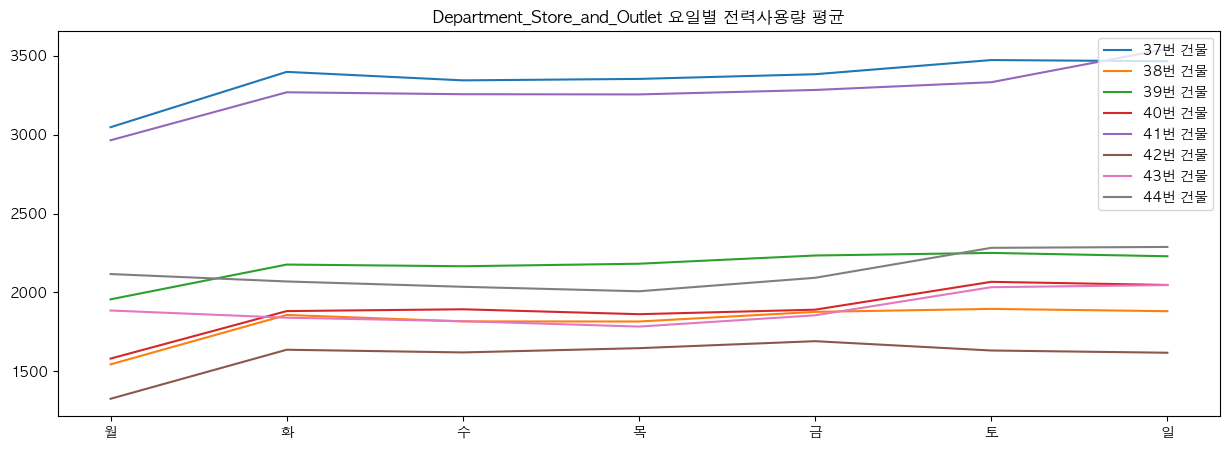

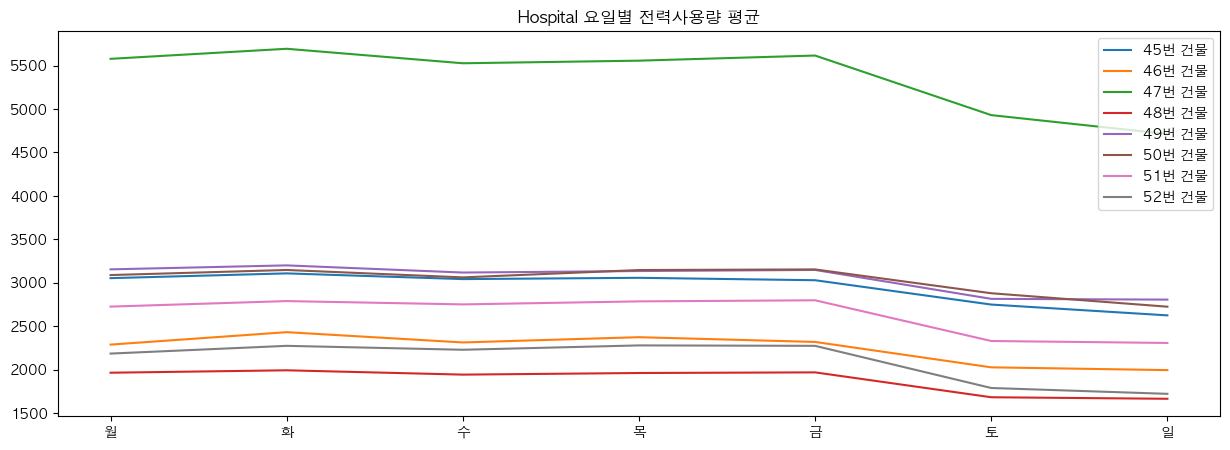

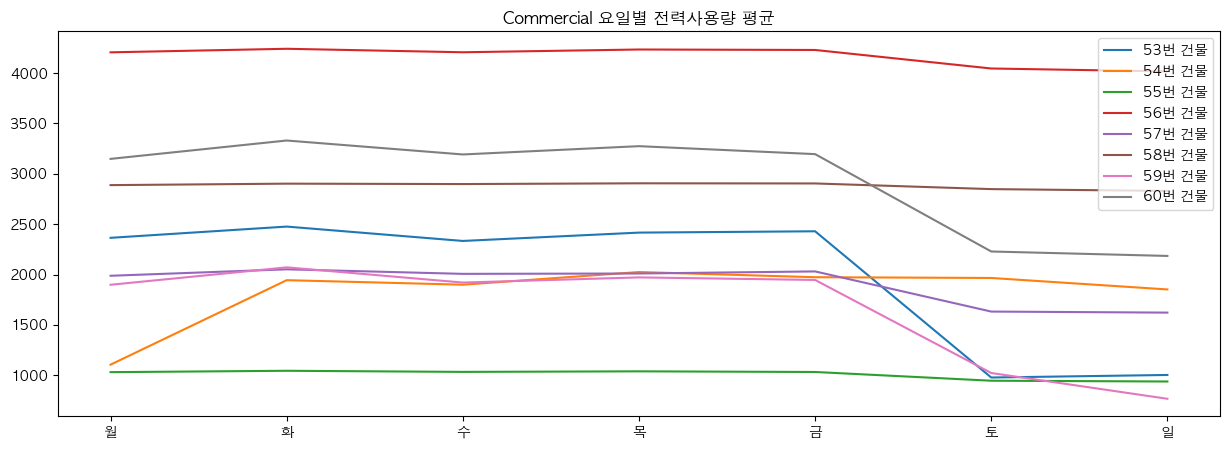

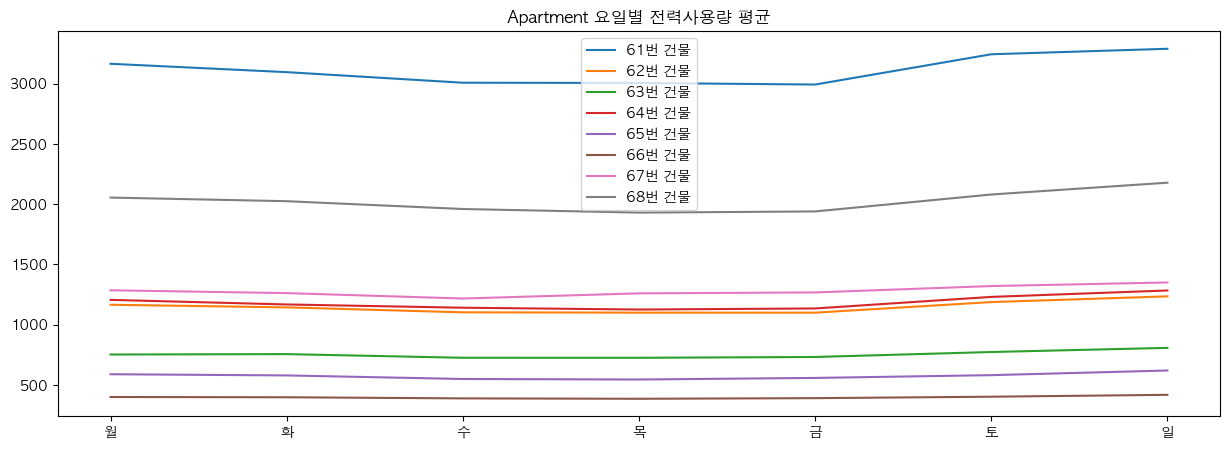

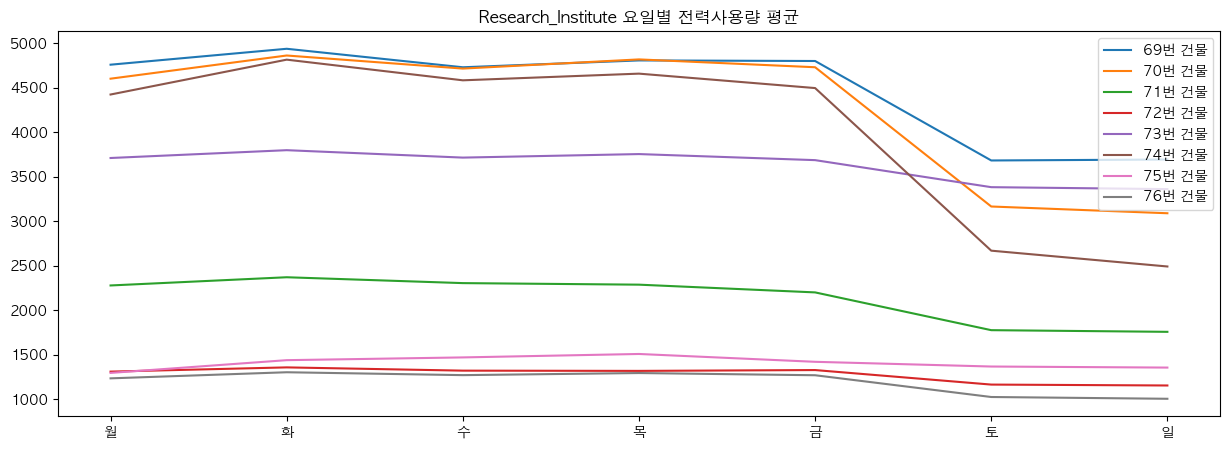

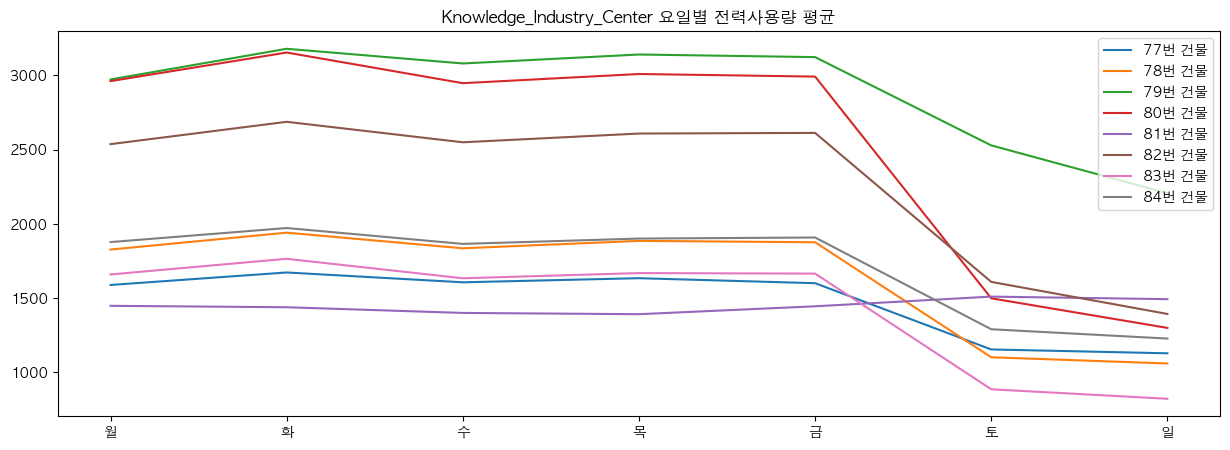

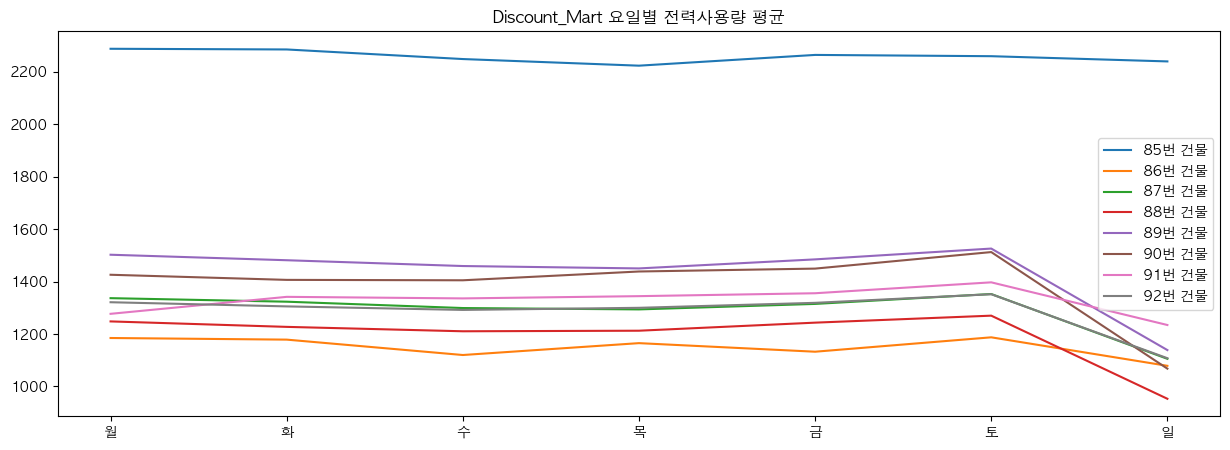

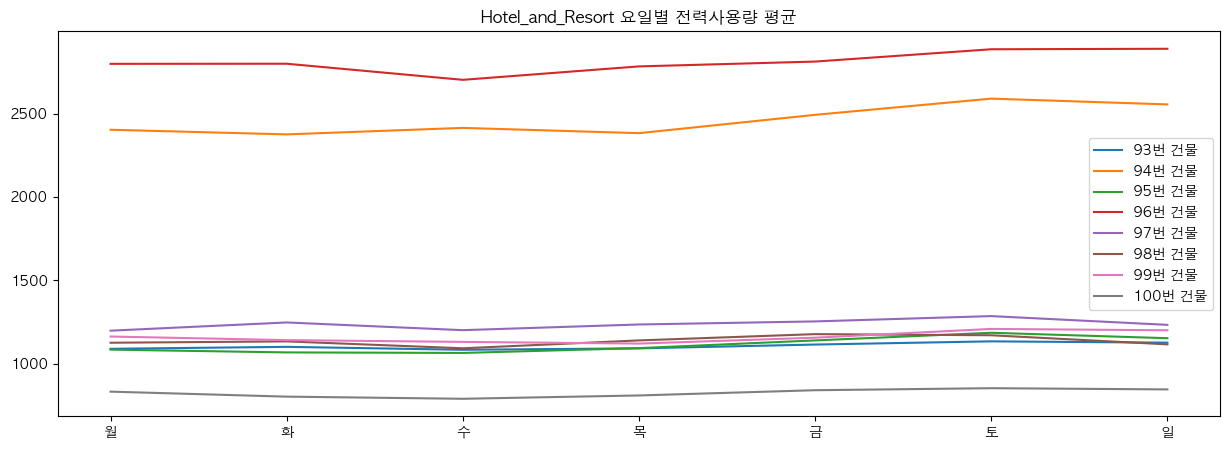

In [210]:
건물별_요일별_전력사용량_평균 = train_df.groupby(['building_number','building_type','day_of_week', ])
건물별_요일별_전력사용량_평균 = 건물별_요일별_전력사용량_평균.power_consumption.mean()

건물별_요일별_전력사용량_평균 = 건물별_요일별_전력사용량_평균.reset_index()
# display(건물별_요일별_전력사용량_평균)
building_type_list = building_info.building_type.unique()
# print(building_type_list)
요일 = ['월', '화', '수', '목', '금', '토', '일']

건물별_요일별_전력사용량_평균 = 건물별_요일별_전력사용량_평균.groupby('building_number')
건물별_요일별_전력사용량_평균.get_group(1)
for i in building_type_list:
    plt.figure(figsize=(15, 5))
    for j in range(1,101):
        if 건물별_요일별_전력사용량_평균.get_group(j).building_type.unique() == i:
            plt.plot(요일, 건물별_요일별_전력사용량_평균.get_group(j).power_consumption, label=f"{j}번 건물")
    plt.title(f'{i} 요일별 전력사용량 평균')
    plt.legend()
    plt.show()

In [ ]:
# 년기준 일 평균 소비전력
train_df['day_of_year'] = train_df['date_time'].dt.dayofyear
mean_power_by_day_of_year = train_df.groupby('day_of_year')['power_consumption'].mean()
# 년기준 시간평균 소비전력
train_df['hour_of_year'] = train_df['date_time'].dt.hour + (train_df['date_time'].dt.dayofyear - 1) * 24
mean_power_by_hour_of_year = train_df.groupby('hour_of_year')['power_consumption'].mean()

# 년기준 월평균 소비전력
mean_power_by_month = train_df.groupby('month')['power_consumption'].mean()

# 일기준 시간 평균 소비전력
mean_power_by_hour = train_df.groupby('hour')['power_consumption'].mean()

# 월기준 시간 평균 소비전력
mean_power_by_day = train_df.groupby('day')['power_consumption'].mean()

In [ ]:
pt = pd.pivot_table(train_df, values=['power_consumption'], index=['day'], aggfunc={'power_consumption': [np.sum, max]})
# display(pt)


plt.plot(mean_power_by_day.index[:-1],pt.power_consumption['sum'][:-1])
plt.title('sum Power Consumption by Day of the Month')
plt.xlabel('Day of the Month')
plt.ylabel('sum Power Consumption(kWh)')
plt.show()

plt.plot(mean_power_by_day.index,pt.power_consumption['max'])
plt.title('Max Power Consumption by Day of the Month')
plt.xlabel('Day of the Month')
plt.ylabel('Max Power Consumption(kWh)')
plt.show()

In [ ]:
gr = train_df.groupby(['year','month','building_number']).power_consumption.mean()
gr = gr.reset_index()
gr

for i in [6, 7, 8]:
    D = gr[gr.month==i]
    plt.figure(figsize=(10, 4))
    plt.bar(D.building_number,D.power_consumption)
    # plt.title('Mean Power Consumption by Day of the Year')
    # plt.xlabel('Day of the Year')
    # plt.ylabel('Mean Power Consumption(kWh)')
    plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['power_consumption'], bins=100, kde=True)
plt.title('건물별 시간당 전력 소비량 빈도')
plt.xlabel('시간당 전력 소비량(kWh)')
# plt.ylabel('Frequency')
plt.show()

In [ ]:
gr[gr.month==6][gr[gr.month==6].power_consumption==max(gr[gr.month==6].power_consumption)]

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(mean_power_by_day_of_year.index,mean_power_by_day_of_year.values)
plt.title('Mean Power Consumption by Day of the Year')
plt.xlabel('Day of the Year')
plt.ylabel('Mean Power Consumption(kWh)')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(mean_power_by_hour_of_year.index,mean_power_by_hour_of_year.values)
plt.title('Mean Power Consumption by Hour of the Year')
plt.xlabel('Hour of the Year')
plt.ylabel('Mean Power Consumption(kWh)')
plt.show()

NameError: name 'mean_power_by_hour' is not defined

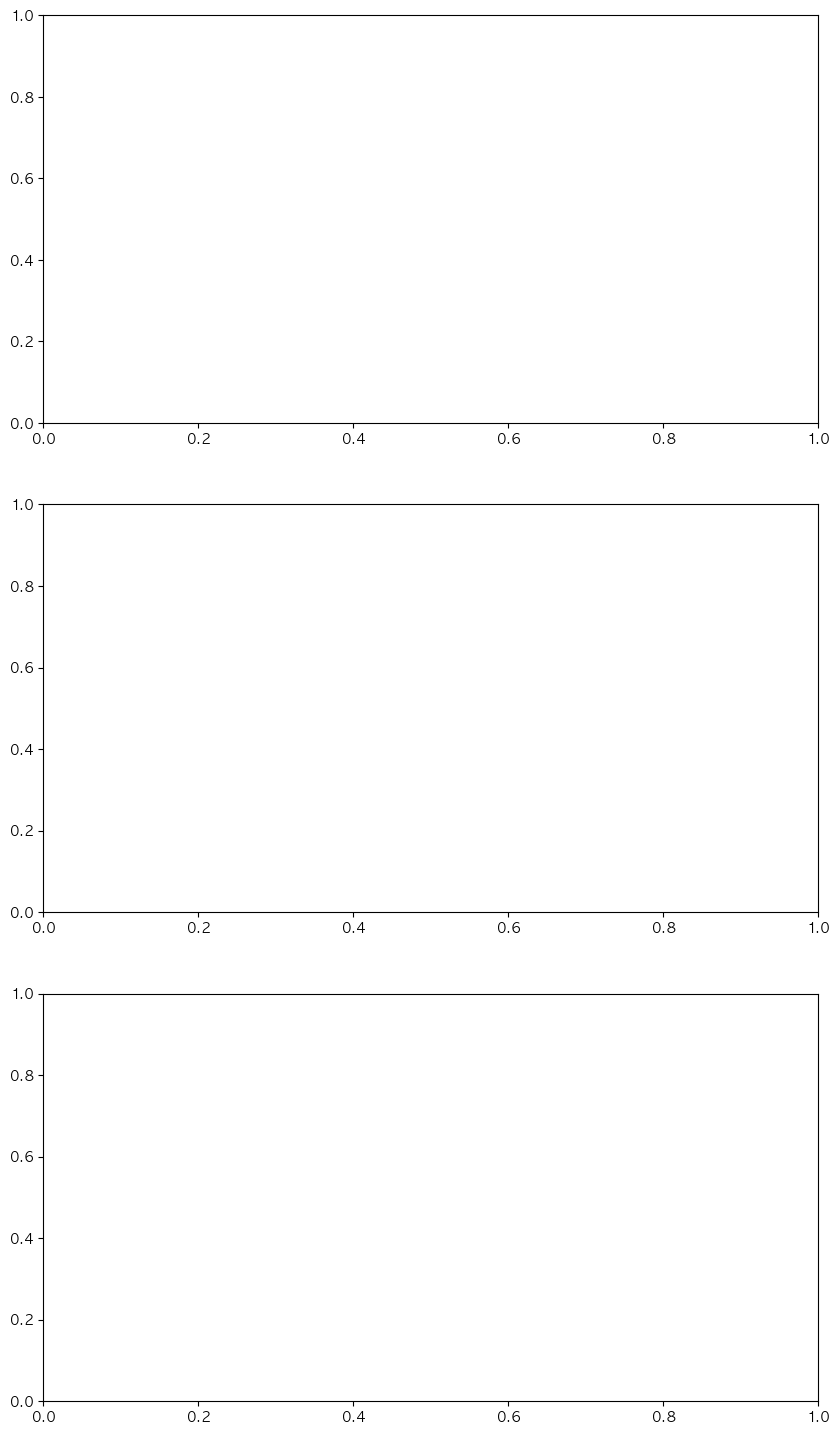

In [211]:
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Plot mean power consumption by hour of the day
axs[0].plot(mean_power_by_hour.index,mean_power_by_hour.values)
axs[0].set_title('Mean Power Consumption by Hour of the Day')
axs[0].set_xlabel('Hour of the Day')
axs[0].set_ylabel('Mean Power Consumption(kWh)')

# Plot mean power consumption by day of the month
axs[1].plot(mean_power_by_day.index,mean_power_by_day.values)
axs[1].set_title('Mean Power Consumption by Day of the Month')
axs[1].set_xlabel('Day of the Month')
axs[1].set_ylabel('Mean Power Consumption(kWh)')

# 년기준 월평균 소비전력
axs[2].bar(mean_power_by_month.index,mean_power_by_month.values)
axs[2].set_title('Mean Power Consumption by Month of the Year')
axs[2].set_xlabel('Month of the Year')
axs[2].set_ylabel('Mean Power Consumption(kWh)')
plt.grid(True, axis='y', alpha=0.5, linestyle='--')

plt.tight_layout()
plt.show()

In [ ]:
추세가 중요하면 

In [ ]:
스라이딩 윈도우

In [ ]:
상관관계를 붆석을 먼저 하고 input output 형태를 결정하고 전처리에 들어가는게 좋다

In [ ]:
lstm - rnn에서 메모리셀을 추가한 장기 기억 가능

gru 매개변수를 줄여서 계산시간을 줄여준다.
어텐션 메커니즘 